m=  -4
2.622557744268158e-05


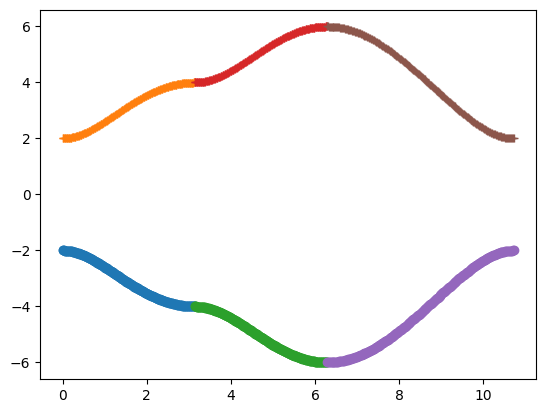

m=  -3
5.2653187340389796e-05


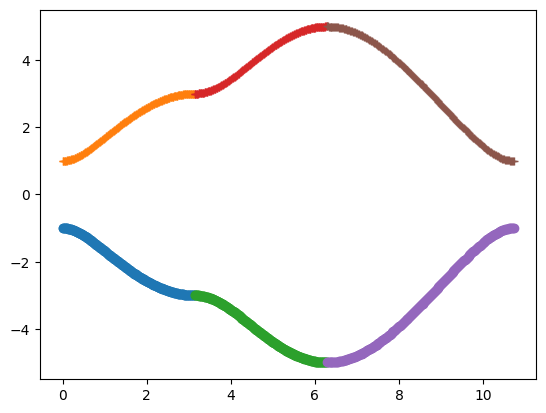

m=  0
-0.007034173499678085


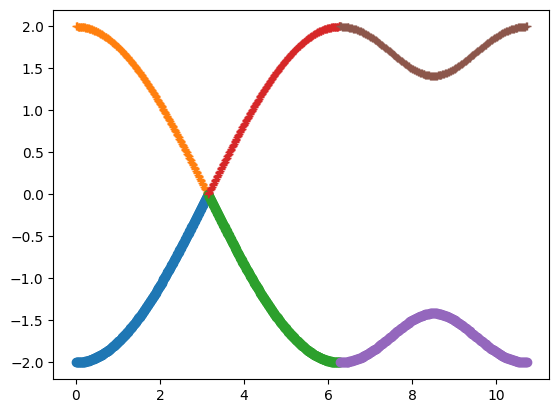

m=  -1
1.0005413827827916


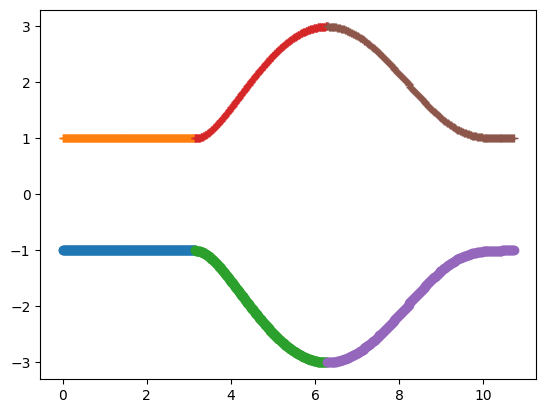

m=  1
-1.0062863268998385


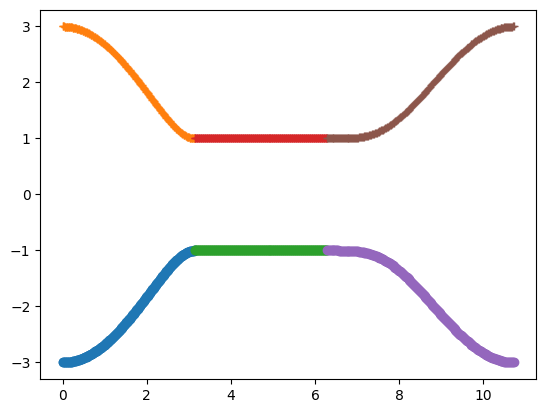

m=  3
0.0005448734412677823


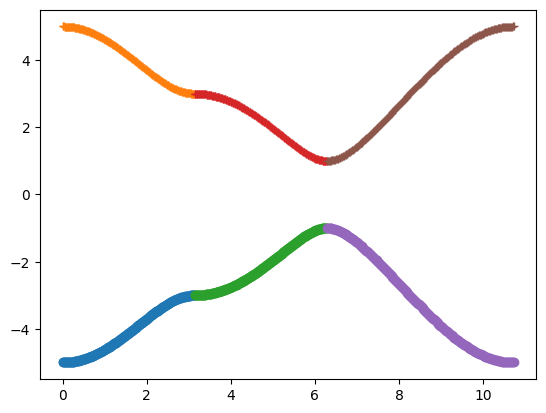

m=  4
0.00013358360198220746


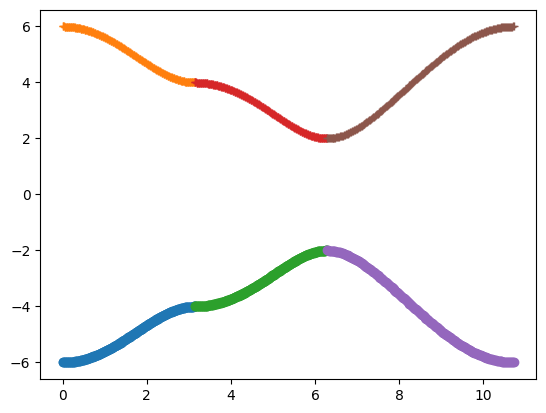

In [1]:
# Written by In-Ho Lee, KRISS, May 12 (2019).
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt


def genh(kx, ky, mm):
    h1 = np.sin(kx)
    h2 = np.sin(ky)
    h3 = mm+np.cos(kx)+np.cos(ky)
    if False:
        tmp = h1**2+h2**2+h3**2
        if tmp < 1.e-13:
            tmp = 0.
        tmp = np.sqrt(tmp)
        if tmp > 1.e-13:
            h1 = h1/tmp
            h2 = h2/tmp
            h3 = h3/tmp
    return h1, h2, h3


def ndotvec(kx, ky, mm, ioption, delk):
    h1, h2, h3 = genh(kx, ky, mm)
    kxp = kx+delk
    wec1, wec2, wec3 = genh(kxp, ky, mm)
    if ioption == 1:
        dhdkx1 = (wec1-h1)/delk
        dhdkx2 = (wec2-h2)/delk
        dhdkx3 = (wec3-h3)/delk
    if ioption == 0:
        kxp = kx-delk
        vec1, vec2, vec3 = genh(kxp, ky, mm)
        dhdkx1 = (wec1-vec1)/(2*delk)
        dhdkx2 = (wec2-vec2)/(2*delk)
        dhdkx3 = (wec3-vec3)/(2*delk)
    kyp = ky+delk
    wec1, wec2, wec3 = genh(kx, kyp, mm)
    if ioption == 1:
        dhdky1 = (wec1-h1)/delk
        dhdky2 = (wec2-h2)/delk
        dhdky3 = (wec3-h3)/delk
    if ioption == 0:
        kyp = ky-delk
        vec1, vec2, vec3 = genh(kx, kyp, mm)
        dhdky1 = (wec1-vec1)/(2*delk)
        dhdky2 = (wec2-vec2)/(2*delk)
        dhdky3 = (wec3-vec3)/(2*delk)
    if ioption == -1:
        dhdkx1 = np.cos(kx)
        dhdkx2 = 0.
        dhdkx3 = -np.sin(kx)
        dhdky1 = 0.
        dhdky2 = np.cos(ky)
        dhdky3 = -np.sin(ky)
    v1 = dhdkx2*dhdky3-dhdkx3*dhdky2
    v2 = dhdkx3*dhdky1-dhdkx1*dhdky3
    v3 = dhdkx1*dhdky2-dhdkx2*dhdky1
    tmq = 0.
    tmp = h1**2+h2**2+h3**2
    if tmp > 1.e-13:
        tmp = np.sqrt(tmp)
        tmp = tmp**3
        tmq = (h1*v1+h2*v2+h3*v3)/tmp
    return tmq


def defint(nx, ny, mm, ioption, delk):
    dx = 2.*np.pi/float(nx-1)
    dy = 2.*np.pi/float(ny-1)
    integral = 0.
    for i in range(nx):
        kx = -np.pi+float(i)*dx
        for j in range(ny):
            ky = -np.pi+float(j)*dy
            integral = integral+ndotvec(kx, ky, mm, ioption, delk)
    return integral*(dx*dy)/(4.*np.pi)


def wvfromham(kx, ky, mm):
    s1 = np.zeros((2, 2), dtype=complex)
    s2 = np.zeros((2, 2), dtype=complex)
    s3 = np.zeros((2, 2), dtype=complex)
    s1[0, 1] = 1.
    s1[1, 0] = 1.
    s2[0, 1] = -1j
    s2[1, 0] = 1j
    s3[0, 0] = 1
    s3[1, 1] = -1
    ham = np.sin(kx)*s1 + np.sin(ky)*s2 + (mm+np.cos(kx) + np.cos(ky))*s3
    assert (np.all(0 == (ham-np.conj(ham.T))))
    w, v = LA.eig(ham)
    idx = w.argsort()
    w = w[idx]
    v = v[:, idx]
    w = w.real
    if False:
        w, v = wvfromham(kx, ky, mm)
        for i in range(2):
            print(w[i])
            print(v[:, i])
        for i in range(2):
            for j in range(2):
                print(v[:, i]@v[:, j])
    return w, v


mmlist = [-4, -3, 0, -1, 1, 3, 4]
for mm in mmlist:
    print('m= ', mm)

    nx = 1001
    ny = nx
    delk = 1.e-4
    ioption = -1
    integral = defint(nx, ny, mm, ioption, delk)
    print(integral)

    ng = 200
    shift = 0.
    x = []
    y1 = []
    y2 = []
    kvec1 = np.zeros((2), dtype=float)
    kvec2 = np.zeros((2), dtype=float)
    kvec1[0] = 0.
    kvec1[1] = 0.
    kvec2[0] = np.pi
    kvec2[1] = 0.
    for i in range(ng):
        kx = kvec1[0]+float(i)*(kvec2[0]-kvec1[0])/float(ng-1)
        ky = kvec1[1]+float(i)*(kvec2[1]-kvec1[1])/float(ng-1)
        w, v = wvfromham(kx, ky, mm)
        tmp = np.sqrt((kx-kvec1[0])**2+(ky-kvec1[1])**2)
        x.append(tmp+shift)
        y1.append(w[0])
        y2.append(w[1])
    x = np.asarray(x)
    y1 = np.asarray(y1)
    y2 = np.asarray(y2)
    fig, ax = plt.subplots()
    ax.plot(x, y1, 'o')
    ax.plot(x, y2, '+')

    shift = x[-1]
    x = []
    y1 = []
    y2 = []
    kvec1[0] = np.pi
    kvec1[1] = 0.
    kvec2[0] = np.pi
    kvec2[1] = np.pi
    for i in range(ng):
        kx = kvec1[0]+float(i)*(kvec2[0]-kvec1[0])/float(ng-1)
        ky = kvec1[1]+float(i)*(kvec2[1]-kvec1[1])/float(ng-1)
        tmp = np.sqrt((kx-kvec1[0])**2+(ky-kvec1[1])**2)
        w, v = wvfromham(kx, ky, mm)
        x.append(tmp+shift)
        y1.append(w[0])
        y2.append(w[1])
    x = np.asarray(x)
    y1 = np.asarray(y1)
    y2 = np.asarray(y2)
    ax.plot(x, y1, 'o')
    ax.plot(x, y2, '+')

    shift = x[-1]
    x = []
    y1 = []
    y2 = []
    kvec1[0] = np.pi
    kvec1[1] = np.pi
    kvec2[0] = 0.
    kvec2[1] = 0.
    for i in range(ng):
        kx = kvec1[0]+float(i)*(kvec2[0]-kvec1[0])/float(ng-1)
        ky = kvec1[1]+float(i)*(kvec2[1]-kvec1[1])/float(ng-1)
        tmp = np.sqrt((kx-kvec1[0])**2+(ky-kvec1[1])**2)
        w, v = wvfromham(kx, ky, mm)
        x.append(tmp+shift)
        y1.append(w[0])
        y2.append(w[1])
    x = np.asarray(x)
    y1 = np.asarray(y1)
    y2 = np.asarray(y2)
    ax.plot(x, y1, 'o')
    ax.plot(x, y2, '+')
    # ax.set_title('')
    fig.savefig("band.pdf")
    plt.show()
    plt.close()

m=  -4
2.622557744268158e-05


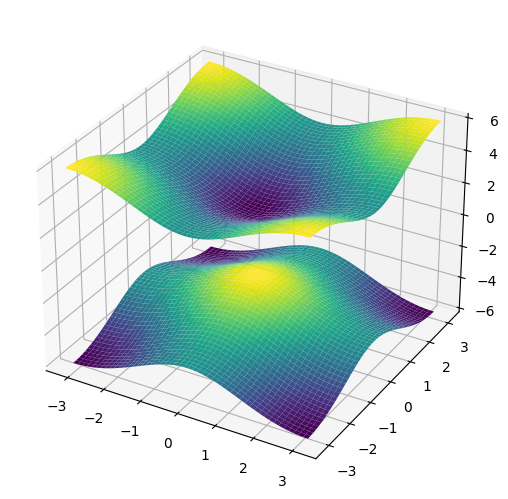

m=  -3
5.2653187340389796e-05


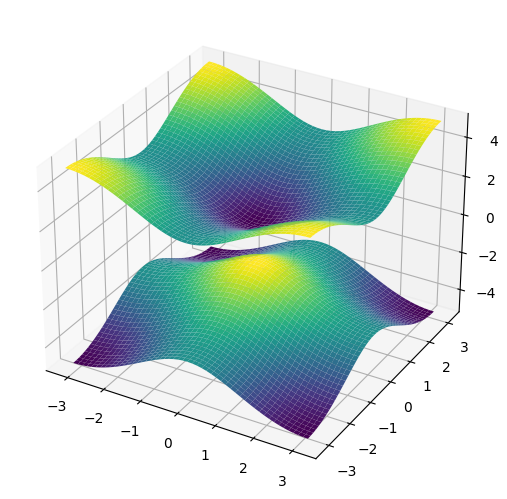

m=  -1
1.0005413827827916


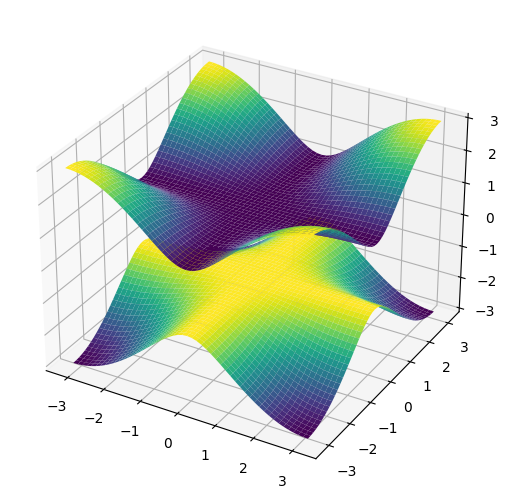

m=  1
-1.0062863268998385


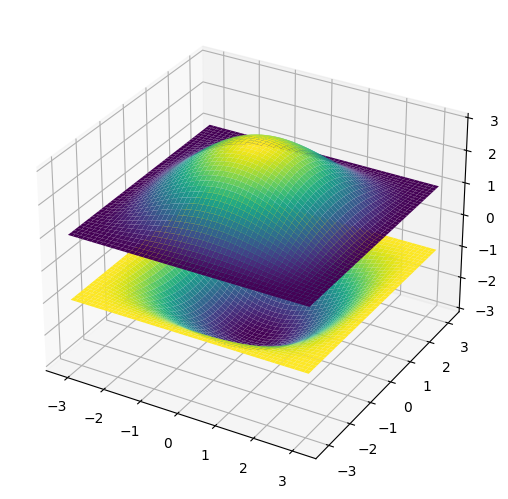

m=  3
0.0005448734412677823


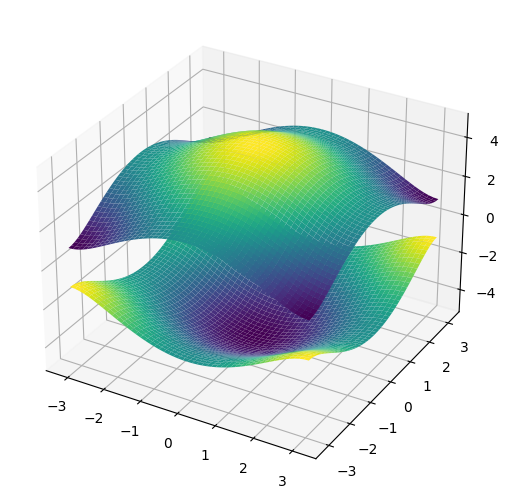

m=  4
0.00013358360198220746


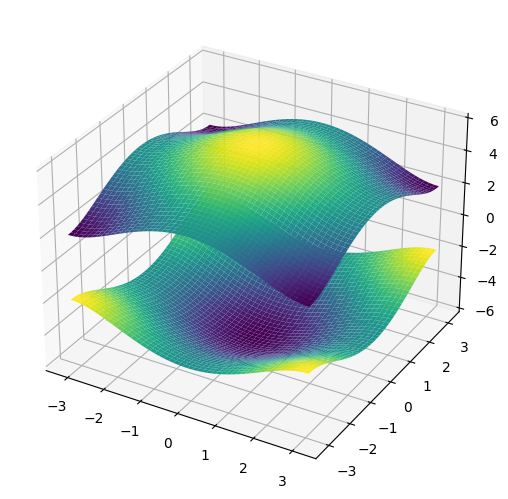

m=  0
-0.0070216071290638594


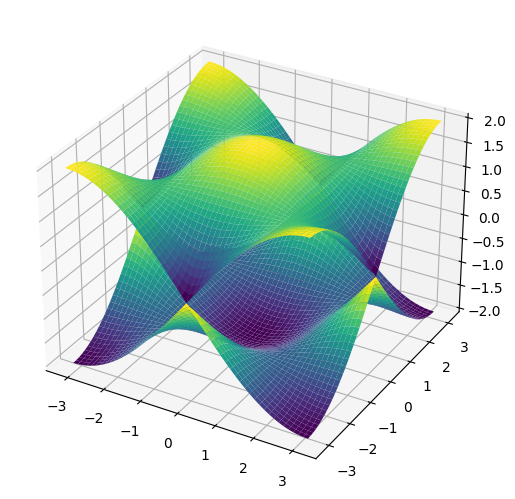

In [2]:
# Written by In-Ho Lee, KRISS, May 12 (2019).
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from numpy import linalg as LA


def genh(kx, ky, mm):
    h1 = np.sin(kx)
    h2 = np.sin(ky)
    h3 = mm+np.cos(kx)+np.cos(ky)
    if False:
        tmp = h1**2+h2**2+h3**2
        if tmp < 1.e-13:
            tmp = 0.
        tmp = np.sqrt(tmp)
        if tmp > 1.e-13:
            h1 = h1/tmp
            h2 = h2/tmp
            h3 = h3/tmp
    return h1, h2, h3


def ndotvec(kx, ky, mm, ioption, delk):
    h1, h2, h3 = genh(kx, ky, mm)
    kxp = kx+delk
    wec1, wec2, wec3 = genh(kxp, ky, mm)
    if ioption == 1:
        dhdkx1 = (wec1-h1)/delk
        dhdkx2 = (wec2-h2)/delk
        dhdkx3 = (wec3-h3)/delk
    if ioption == 0:
        kxp = kx-delk
        vec1, vec2, vec3 = genh(kxp, ky, mm)
        dhdkx1 = (wec1-vec1)/(2*delk)
        dhdkx2 = (wec2-vec2)/(2*delk)
        dhdkx3 = (wec3-vec3)/(2*delk)
    kyp = ky+delk
    wec1, wec2, wec3 = genh(kx, kyp, mm)
    if ioption == 1:
        dhdky1 = (wec1-h1)/delk
        dhdky2 = (wec2-h2)/delk
        dhdky3 = (wec3-h3)/delk
    if ioption == 0:
        kyp = ky-delk
        vec1, vec2, vec3 = genh(kx, kyp, mm)
        dhdky1 = (wec1-vec1)/(2*delk)
        dhdky2 = (wec2-vec2)/(2*delk)
        dhdky3 = (wec3-vec3)/(2*delk)
    if ioption == -1:
        dhdkx1 = np.cos(kx)
        dhdkx2 = 0.
        dhdkx3 = -np.sin(kx)
        dhdky1 = 0.
        dhdky2 = np.cos(ky)
        dhdky3 = -np.sin(ky)
    v1 = dhdkx2*dhdky3-dhdkx3*dhdky2
    v2 = dhdkx3*dhdky1-dhdkx1*dhdky3
    v3 = dhdkx1*dhdky2-dhdkx2*dhdky1
    tmq = 0.
    tmp = h1**2+h2**2+h3**2
    if tmp > 1.e-13:
        tmp = np.sqrt(tmp)
        tmp = tmp**3
    tmq = (h1*v1+h2*v2+h3*v3)/tmp
    return tmq


def defint(nx, ny, mm, ioption, delk):
    dx = 2.*np.pi/float(nx-1)
    dy = 2.*np.pi/float(ny-1)
    integral = 0.
    for i in range(nx):
        kx = -np.pi+float(i)*dx
        for j in range(ny):
            ky = -np.pi+float(j)*dy
            integral = integral+ndotvec(kx, ky, mm, ioption, delk)
    return integral*(dx*dy)/(4.*np.pi)


def wvfromham(kx, ky, mm):
    s1 = np.zeros((2, 2), dtype=complex)
    s2 = np.zeros((2, 2), dtype=complex)
    s3 = np.zeros((2, 2), dtype=complex)
    s1[0, 1] = 1.
    s1[1, 0] = 1.
    s2[0, 1] = -1j
    s2[1, 0] = 1j
    s3[0, 0] = 1
    s3[1, 1] = -1
    ham = np.sin(kx)*s1 + np.sin(ky)*s2 + (mm+np.cos(kx) + np.cos(ky))*s3
    assert (np.all(0 == (ham-np.conj(ham.T))))
    w, v = LA.eig(ham)
    idx = w.argsort()
    w = w[idx]
    v = v[:, idx]
    w = w.real
    if False:
        w, v = wvfromham(kx, ky, mm)
        for i in range(2):
            print(w[i])
            print(v[:, i])
        for i in range(2):
            for j in range(2):
                print(v[:, i]@v[:, j])
    return w, v


mmlist = [-4, -3, -1, 1, 3, 4, 0]
for mm in mmlist:
    print('m= ', mm)

    nx = 1001
    ny = nx
    delk = 1.e-4
    ioption = -1
    integral = defint(nx, ny, mm, ioption, delk)
    print(integral)

    nx = 51
    ny = nx
    x = np.zeros(nx)
    y = np.zeros(ny)
    Z = np.zeros((nx, ny))
    W = np.zeros((nx, ny))
    dx = 2.*np.pi/float(nx-1)
    dy = 2.*np.pi/float(ny-1)
    for i in range(nx):
        x[i] = -np.pi+float(i)*dx
    for j in range(ny):
        y[j] = -np.pi+float(j)*dy

    for i in range(nx):
        kx = x[i]
        for j in range(ny):
            ky = y[j]
            w, v = wvfromham(kx, ky, mm)
            Z[i, j] = w[0]
            W[i, j] = w[1]
    X, Y = np.meshgrid(x, y)

    fig = plt.figure()
#    ax = Axes3D(fig)
    ax = Axes3D(fig, auto_add_to_figure=False)
    fig.add_axes(ax)
    ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.viridis)
    ax.plot_surface(X, Y, W, rstride=1, cstride=1, cmap=cm.viridis)
    # ax.set_title('')
    fig.savefig("band3d.pdf")
    plt.show()
    plt.close()